Install dependencies

In [5]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 7.5 MB/s eta 0:00:00


In [6]:
!pip install pytesseract

In [2]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 21.5 MB/s eta 0:00:00


Load Needed libraries

In [7]:
import cv2
from PIL import Image

In [8]:
from skimage.segmentation import clear_border
import pytesseract
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [9]:
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

Using TensorFlow backend


In [10]:
import easyocr
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

cd to project folder

In [14]:
cd /content/drive/MyDrive/ML Projs/pascal

/content/drive/MyDrive/ML Projs/pascal


Load the train and val data.

The folder contains both the images and the xml files

In [12]:
#per the annotation, the boxes were labelled as 'License-Plate', 'No-Plate', 'license', 'object'
class_ids = [
    'License-Plate', 'No-Plate', 'license', 'object'
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to image folder
train_path = "train/"
val_path = "valid/"

#Get all xml files in the path
train_xml_files = sorted(
    [
        os.path.join(train_path, file_name)
        for file_name in os.listdir(train_path)
        if file_name.endswith(".xml")
    ]
)

valid_xml_files = sorted(
    [
        os.path.join(val_path, file_name)
        for file_name in os.listdir(val_path)
        if file_name.endswith(".xml")
    ]
)

# Get all .jpg files in the path
train_jpg_files = sorted(
    [
        os.path.join(train_path, file_name)
        for file_name in os.listdir(train_path)
        if file_name.endswith(".jpg")
    ]
)

val_jpg_files = sorted(
    [
        os.path.join(val_path, file_name)
        for file_name in os.listdir(val_path)
        if file_name.endswith(".jpg")
    ]
)

We need to extract the bounding box coordinate and the class from the xml file. an example of the xml file looks like this

In [55]:
# '''python
# 	<folder></folder>
# 	<filename>0af2e6a3-4ea7-4ab6-a4ab-8382b8533375_jpg.rf.125c167d4ee8d54fefdb8114d8365e6b.jpg</filename>
# 	<path>0af2e6a3-4ea7-4ab6-a4ab-8382b8533375_jpg.rf.125c167d4ee8d54fefdb8114d8365e6b.jpg</path>
# 	<source>
# 		<database>roboflow.ai</database>
# 	</source>
# 	<size>
# 		<width>640</width>
# 		<height>640</height>
# 		<depth>3</depth>
# 	</size>
# 	<segmented>0</segmented>
# 	<object>
# 		<name>No-Plate</name>
# 		<pose>Unspecified</pose>
# 		<truncated>0</truncated>
# 		<difficult>0</difficult>
# 		<occluded>0</occluded>
# 		<bndbox>
# 			<xmin>415</xmin>
# 			<xmax>481</xmax>
# 			<ymin>360</ymin>
# 			<ymax>434</ymax>
# 		</bndbox>
# 	</object>
# '''

In [13]:
def parse_annotation(xml_file, path):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # load the xml file and get the file name
    image_name = root.find("filename").text
    image_path = os.path.join(path, image_name)

    #Get bounding boxes coord and classes
    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids

In [14]:
def get_bbox(xml_files, path):
    image_paths = []
    bbox = []
    classes = []
    for xml_file in tqdm(xml_files):
        image_path, boxes, class_ids = parse_annotation(xml_file, path)
        image_paths.append(image_path)
        bbox.append(boxes)
        classes.append(class_ids)
    return image_paths, bbox, classes

In [23]:
train_img_path, train_bbox, train_classe = get_bbox(train_xml_files, train_path)

  0%|          | 0/2070 [00:00<?, ?it/s]

In [24]:
val_img_path, val_bbox, val_classe = get_bbox(valid_xml_files, val_path)

  0%|          | 0/220 [00:00<?, ?it/s]

convert to tf data

In [25]:
train_bbox = tf.ragged.constant(train_bbox)
train_classes = tf.ragged.constant(train_classe)
train_img_path = tf.ragged.constant(train_img_path)

train_data = tf.data.Dataset.from_tensor_slices((train_img_path, train_classes, train_bbox))

In [26]:
val_bbox = tf.ragged.constant(val_bbox)
val_classes = tf.ragged.constant(val_classe)
val_img_path = tf.ragged.constant(val_img_path)

val_data = tf.data.Dataset.from_tensor_slices((val_img_path, val_classes, val_bbox))

In [11]:
#function to load image
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


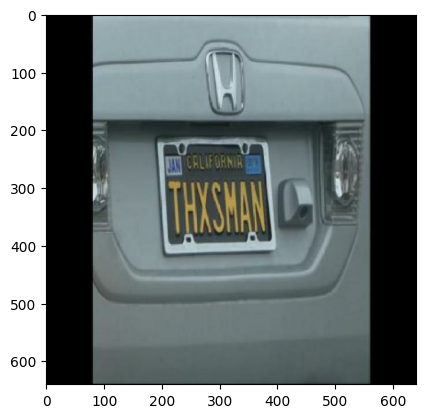

In [32]:
plt.imshow(load_image(train_jpg_files[0]));

In [33]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

In [16]:
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 10
GLOBAL_CLIPNORM = 10.0

In [36]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [37]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [38]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize train data

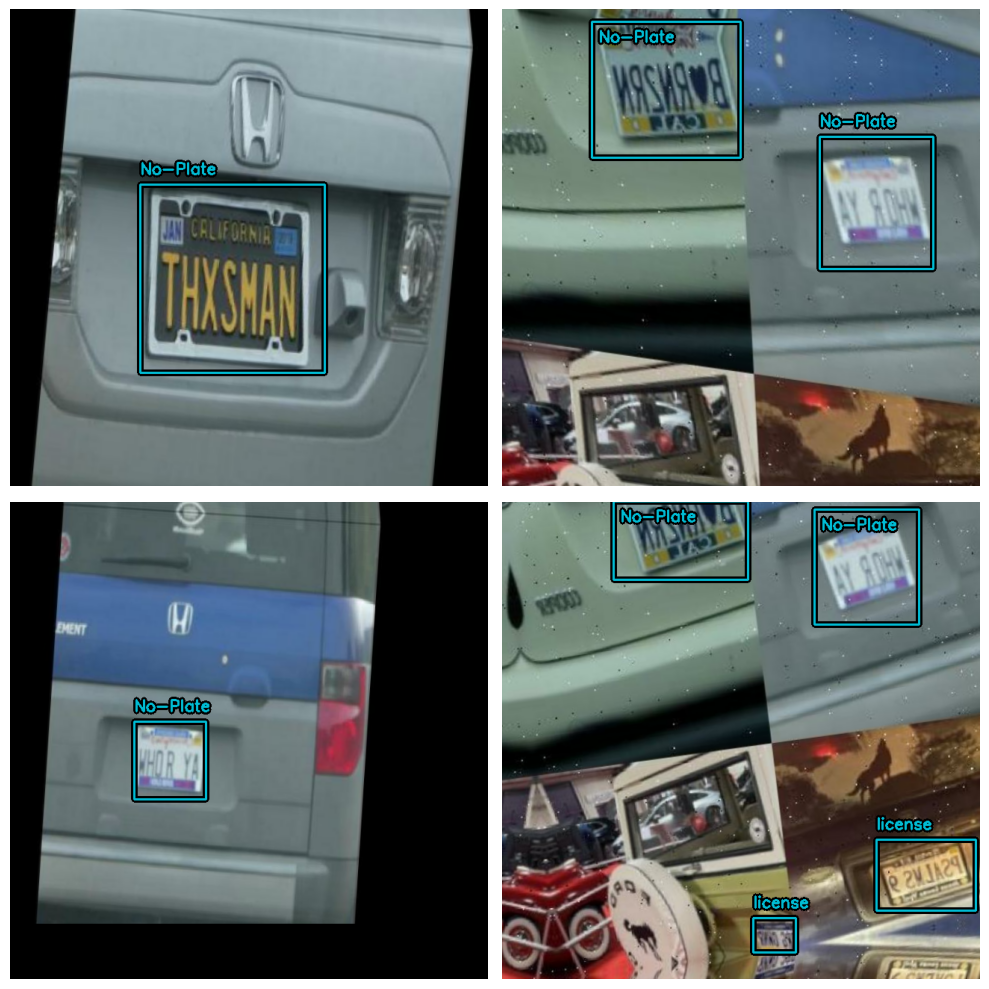

In [39]:
visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize val data

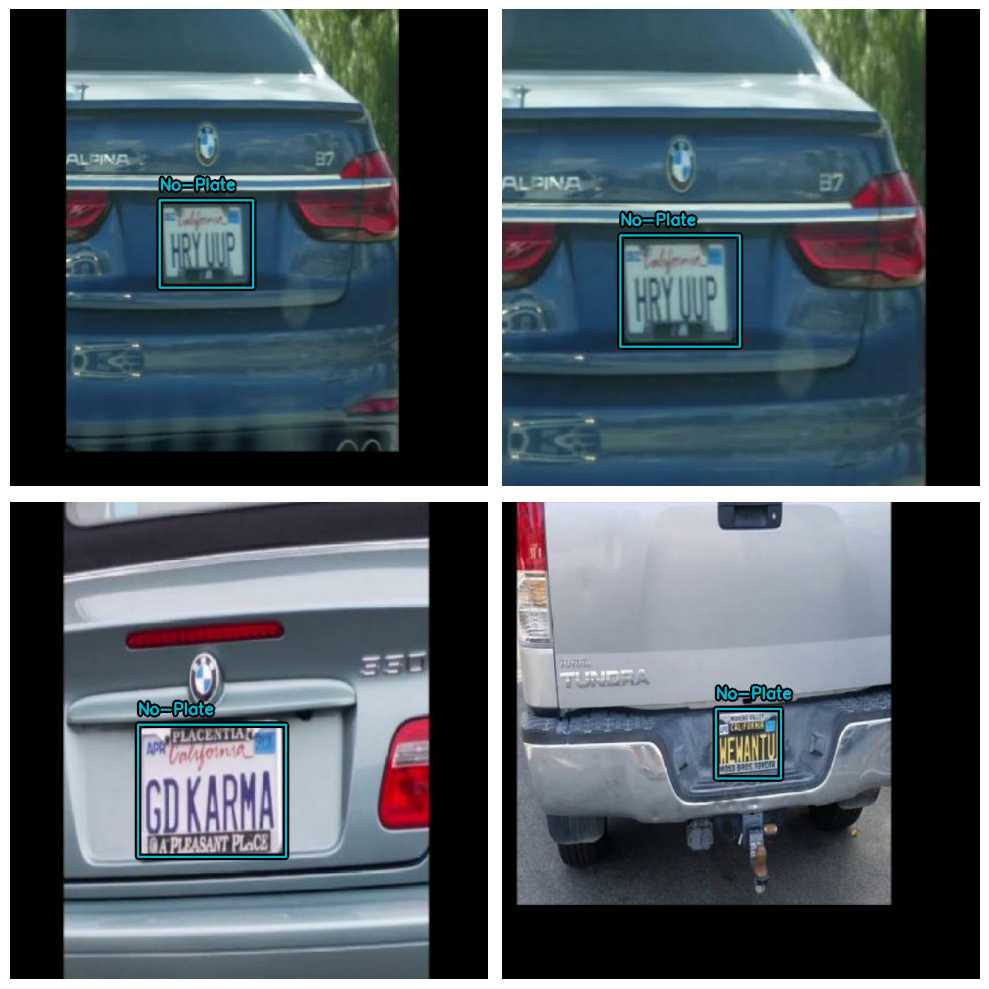

In [40]:
visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [41]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

load yolov8 pretrained weights

In [42]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco", load_weights=True
    #"yolo_v8_m_backbone_coco"
)

20596968/20596968 [==============================] - 0s 0us/step


In [51]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

In [52]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [53]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [54]:
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=EvaluateCOCOMetricsCallback(val_ds, "yolo_model.keras"),
)

Epoch 1/10
517/517 [==============================] - 349s 608ms/step - loss: 21.1814 - box_loss: 2.7684 - class_loss: 18.4129 - val_loss: 4.2004 - val_box_loss: 2.8492 - val_class_loss: 1.3513 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 2/10
517/517 [==============================] - 301s 579ms/step - loss: 3.5942 - box_loss: 2.5468 - class_loss: 1.0474 - val_loss: 3.8868 - val_box_loss: 2.5191 - val_class_loss: 1.3677 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_de

1/1 [==============================] - 0s 308ms/step


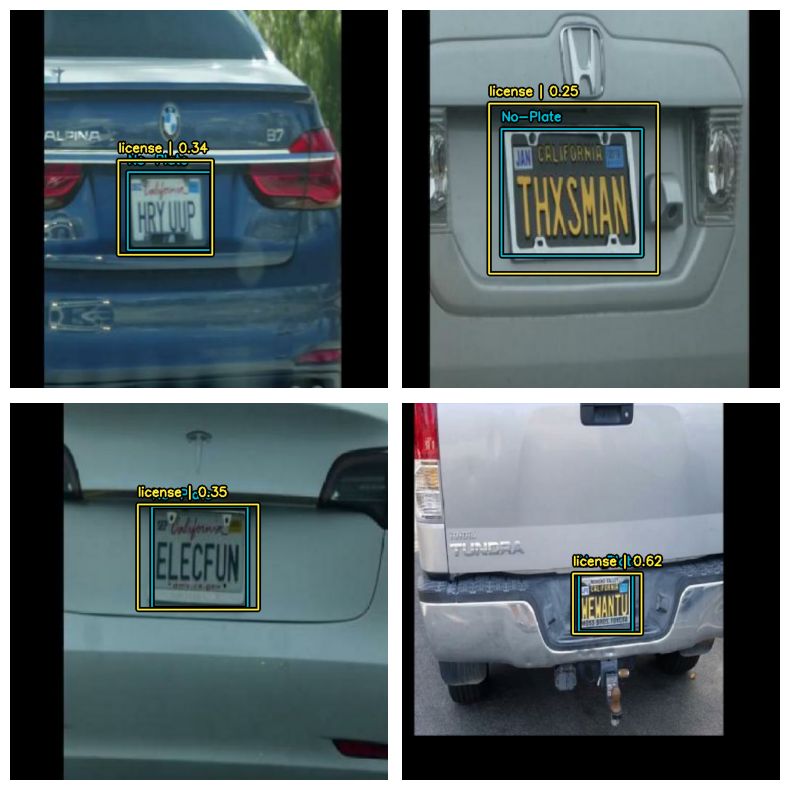

In [56]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")

In [40]:
img = load_image("/content/plate.jpeg")

In [18]:
img = load_image("/content/plate.jpeg")

In [19]:
img2 = cv2.resize(img.numpy(), (640, 640))

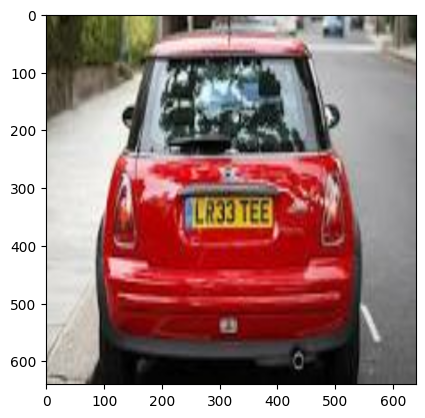

In [20]:
plt.imshow(img2)

In [21]:
img2 = np.expand_dims(img2, 0)

Make Inference on random image

In [ ]:
def get_license_plate(image: np.ndarray, model):
    image = cv2.resize(image, (640, 640))
    img = np.expand_dims(image, 0)
    ypred = model.predict(img)
    ypred = bounding_box.to_ragged(ypred)
    bb = ypred["boxes"].numpy()[0]
    for box in bb:
        x1,y1,x2,y2 = box
        cropped_img = image[int(y1):int(y2), int(x1):int(x2)]
        plt.imshow(cropped_img)

1/1 [==============================] - 0s 109ms/step


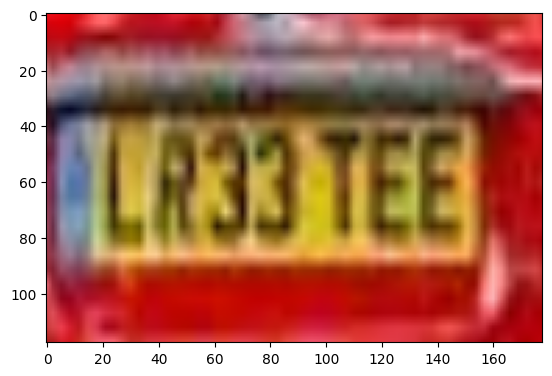

In [138]:
image = load_image("/content/plate.jpeg")
get_license_plate(image.numpy(), yolo)

In [ ]:
yt= yolo.predict(img)

In [77]:
yt = bounding_box.to_ragged(yt)

In [78]:
yt

{'boxes': <tf.RaggedTensor [[[237.9383, 280.10062, 415.3754, 398.47943]]]>,
 'confidence': <tf.RaggedTensor [[0.33288538]]>,
 'classes': <tf.RaggedTensor [[2.0]]>,
 'num_detections': array([1], dtype=int32)}

In [95]:
img_size = cv2.resize(img.numpy(), (640, 640))

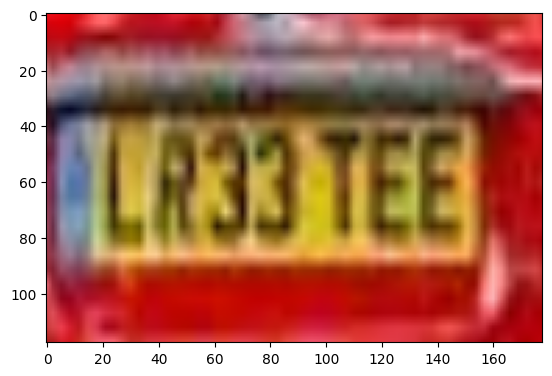

In [97]:
plt.imshow(img_size[280:398,237:415])

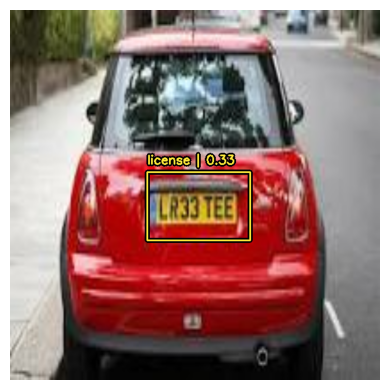

In [86]:
visualization.plot_bounding_box_gallery(
        img2,
        value_range=(0, 255),
        bounding_box_format="xyxy",
        #y_true=y_true,
        y_pred=yt,
        scale=4,
        rows=1,
        cols=1,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )